### 1. Import dependencies for the project

In [8]:
import cv2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, mean_squared_error
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

### 2. Function to get datas

In [9]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

### 3. Loading datas

In [ ]:
train = get_data('../xRay/train')
test = get_data('../xRay/test')
val = get_data('../xRay/val')

### 4. Data Visualization Train Dataset

<Axes: ylabel='count'>

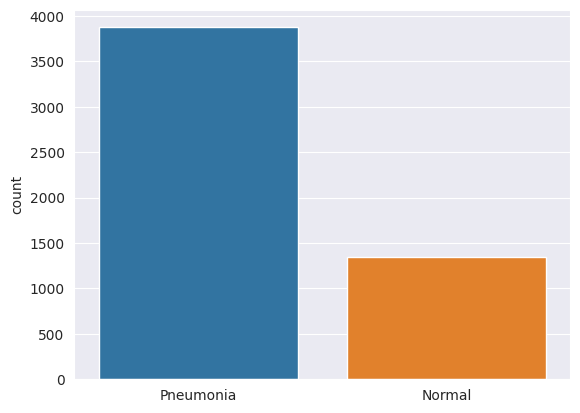

In [11]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
        
sns.set_style('darkgrid')
sns.countplot(x=l)

In [12]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

### Grayscale normalization

In [13]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

### Data augmentation

In [14]:
# Define the data augmentation parameters
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Fit the data augmentation parameters on the training data
datagen.fit(x_train.reshape(-1, img_size, img_size, 1))

# Generate augmented images
augmented_data = datagen.flow(x_train.reshape(-1, img_size, img_size, 1), y_train, batch_size=len(x_train), shuffle=True)

# Extract the augmented images and labels
x_train_augmented, y_train_augmented = augmented_data.next()

### Resizing to 2D array and add augmented images

In [15]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
x_train_augmented = x_train_augmented.reshape(x_train_augmented.shape[0], -1)

x_train = np.concatenate((x_train, x_train_augmented), axis=0)
y_train = np.concatenate((y_train, y_train_augmented), axis=0)

### Hyperparameters

In [ ]:
# Step 5: Fine-tune the hyperparameters if necessary
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10], 'kernel': ['rbf', 'linear']}
# do cross valitdation to tune hyperparameters
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(x_train, y_train)
print("Best parameters:", grid.best_params_)
print("Best estimator:", grid.best_estimator_)

### Train model

In [16]:
# Instantiate the SVC model
svm = SVC(kernel='linear', C=0.1, gamma=0.1)

# Fit the model on the entire training set
svm.fit(x_train, y_train)

SVC(C=0.1, gamma=0.1, kernel='linear')

### Init function to show confusion matrix and ROC curve

In [17]:
def showConfusionMatrix(cf_matrix) :
        group_names = ['True Neg','False Pos','False Neg','True Pos']

        group_counts = ["{0:0.0f}".format(value) for value in
                        cf_matrix.flatten()]

        group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]

        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
                zip(group_names,group_counts,group_percentages)]

        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

        plt.title('Confusion Matrix')

        plt.show()


def showRocCurve(fpr, tpr, roc_auc) :
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

### Predict on Validation dataset

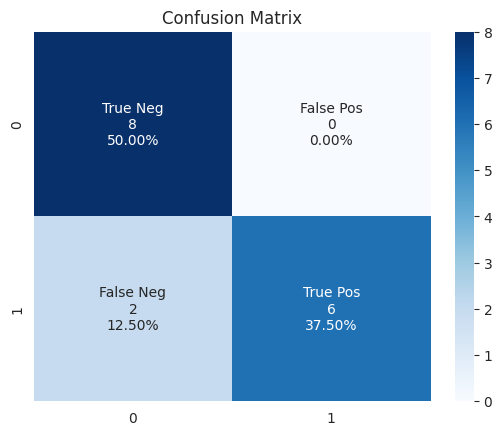

Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.75      0.86         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



In [20]:
# Make predictions on the validation data
y_pred_val = svm.predict(x_val)

# Evaluate the model's performance on the validation data
cm_val = confusion_matrix(y_val, y_pred_val)
cr = classification_report(y_val, y_pred_val)

showConfusionMatrix(cm_val)
print("Classification report:\n", cr)

### Predict on Test dataset

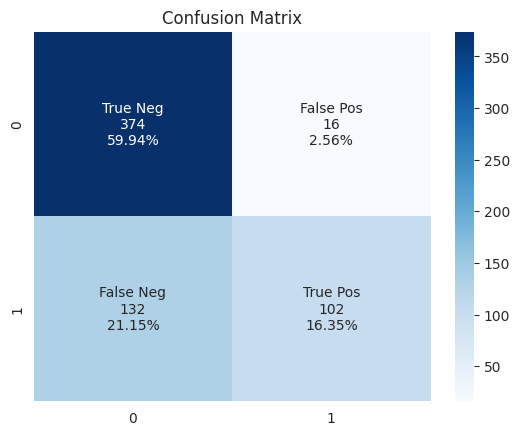

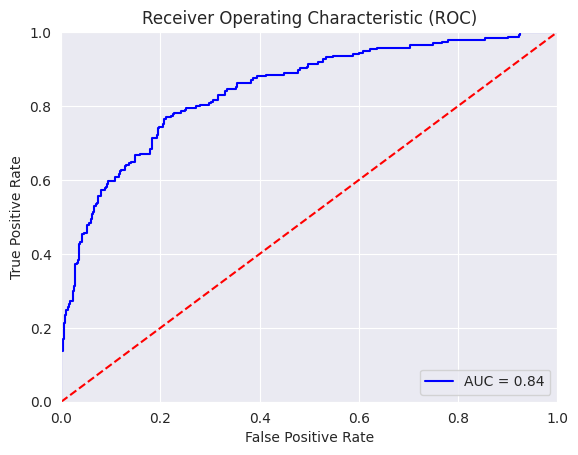

Classification report:
               precision    recall  f1-score   support

           0       0.74      0.96      0.83       390
           1       0.86      0.44      0.58       234

    accuracy                           0.76       624
   macro avg       0.80      0.70      0.71       624
weighted avg       0.79      0.76      0.74       624



In [21]:
# Test the final model on the test data
y_pred_test = svm.predict(x_test)

# Compute the probabilities of belonging to the positive class
y_score_test = svm.decision_function(x_test)

# Compute the false positive rate (fpr), true positive rate (tpr) and the threshold
fpr, tpr, threshold = roc_curve(y_test, y_score_test)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

cm_test = confusion_matrix(y_test, y_pred_test)

cr_test = classification_report(y_test, y_pred_test)

showConfusionMatrix(cm_test)
showRocCurve(fpr, tpr, roc_auc)
print("Classification report:\n", cr_test)

# Report of the SVM model performances

On the positive side, it has a high true negative rate of almost 60%, which means it correctly identified most negative cases. However, the false negative rate is also relatively high at over 20%, which is not ideal for medical applications where missing positive cases can be serious.

The AUC value of 0.84 is more relevant, as it indicates that the model has a good ability to distinguish between positive and negative cases.

Looking at the precision, recall, and f1-score in the classification report, the precision for class 1 is relatively high at 0.86, which means that when the model predicts a positive case, it is correct almost 9 out of 10 times. However, the recall for class 1 is low at 0.44, which means that the model is missing almost 6 out of 10 positive cases. The f1-score for class 1 is also relatively low at 0.58, indicating that the model's overall performance in detecting positive cases could be improved.

Overall, the SVM model is decent, but there is definitely room for improvement in reducing the false negative rate and improving the model's overall ability to detect positive cases.